# 1 Import Libiraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import lightgbm as lgb
import gc

# 2 Prepare Data

In [2]:
train = pd.read_csv('data/train_after_missing_value.csv')
test = pd.read_csv('data/test_after_missing_value.csv')

In [3]:
train.shape

(553287, 289)

In [4]:
test.shape

(499806, 289)

In [5]:
import re
train = train.rename(columns = lambda x:re.sub(':', '', x))

In [6]:
test = test.rename(columns = lambda x:re.sub(':', '', x))

In [7]:
# From https://www.kaggle.com/pavelvpster/ieee-fraud-eda-lightgbm-baseline

from sklearn.preprocessing import LabelEncoder

def encode_categorial_features_fit(df, columns_to_encode):
    encoders = {}
    for c in columns_to_encode:
        if c in df.columns:
            encoder = LabelEncoder()
            encoder.fit(df[c].astype(str).values)
            encoders[c] = encoder
    return encoders

def encode_categorial_features_transform(df, encoders):
    out = pd.DataFrame(index=df.index)
    for c in encoders.keys():
        if c in df.columns:
            out[c] = encoders[c].transform(df[c].astype(str).values)
    return out

c = (train.dtypes == 'object')
categorial_features_columns = list(c[c].index) #categorical features

# categorial_features_columns = [
#     'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21',
#     'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31',
#     'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
#     'DeviceType', 'DeviceInfo', 'ProductCD', 'P_emaildomain', 'R_emaildomain',
#     'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
#     'addr1', 'addr2',
#     'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
#     'P_emaildomain_vendor', 'P_emaildomain_suffix', 'P_emaildomain_us',
#     'R_emaildomain_vendor', 'R_emaildomain_suffix', 'R_emaildomain_us'
# ]

categorial_features_encoders = encode_categorial_features_fit(train, categorial_features_columns)
temp = encode_categorial_features_transform(train, categorial_features_encoders)
columns_to_drop = list(set(categorial_features_columns) & set(train.columns))
train = train.drop(columns_to_drop, axis=1).merge(temp, how='left', left_index=True, right_index=True)
del temp
gc.collect()

0

In [8]:
y_train = train['isFraud'].copy()
x_train = train.drop('isFraud', axis=1)

# del train

gc.collect()

0

In [9]:
percent = 25 # percent of dataset to use for feature selection

x_train_train, x_train_valid, y_train_train, y_train_valid = train_test_split(x_train, y_train, test_size=1.0-percent/100.0, random_state=42)

del x_train
del y_train

gc.collect()

0

In [10]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': False,
    'boost_from_average': True,
    'num_threads': 4,
    
    'num_leaves': 500,
    # 'min_data_in_leaf': 25,
    'max_depth': -1,
    'learning_rate': 0.01
}

# n_jobs=-1 causes out of memory
feature_selector = RFECV(lgb.LGBMClassifier(**params), step=10, scoring='roc_auc', cv=5, verbose=1)
feature_selector.fit(x_train_train, y_train_train)
print('Features selected:', feature_selector.n_features_)

Fitting estimator with 288 features.
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
Fitting estimator with 278 features.
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
Fitting estimator with 268 features.
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
Fitting estimator with 258 features.
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
Fitting estimator with 248 features.
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
Fitting estimator with 238 features.
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
Fitting estimator with 228 features.
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
Fitting estimator with 218 features.
[LightGBM] 

In [11]:
selected_features = [f for f in x_train_train.columns[feature_selector.ranking_ == 1]]

selected_features

['Unnamed 0',
 'TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'dist1',
 'C1',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D10',
 'D11',
 'D15',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V9',
 'V12',
 'V13',
 'V15',
 'V17',
 'V19',
 'V20',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V29',
 'V30',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V59',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V69',
 'V70',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V80',
 'V82',
 'V83',
 'V85',
 'V86',
 'V87',
 'V88',
 'V90',
 'V91',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102',
 'V103',
 'V109',
 'V114',
 'V115',
 'V116',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V130',
 'V131',
 'V132',
 'V133',
 'V

In [12]:
selected = selected_features.copy()
selected.append('isFraud')

In [13]:
train_selected = train[selected]
test_selected = test[selected]

In [14]:
train_selected.shape


(553287, 219)

In [15]:
test_selected.shape

(499806, 219)

In [16]:
train_selected.to_csv('data/train_after_feature_selection.csv')
test_selected.to_csv('data/test_after_feature_selection.csv')

# 3 Compare Score

In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
x_test = x_train_valid
y_test = y_train_valid

In [19]:
percent = 25 # percent of dataset to use for validation

_, x_train_valid_part, _, y_train_valid_part = train_test_split(x_train_valid, y_train_valid, test_size=percent/100.0, random_state=42)

In [20]:
lgb_model = lgb.LGBMClassifier(**params).fit(x_train_train, y_train_train)


In [21]:
y_all_features = lgb_model.predict_proba(x_train_valid_part)[:,1]
score_all_features = roc_auc_score(y_train_valid_part, y_all_features)
print('Score / all features:', score_all_features)

Score / all features: 0.9006741429344988


In [22]:
y_selected_features = feature_selector.estimator_.predict_proba(x_train_valid_part[selected_features])[:,1]
score_selected_features = roc_auc_score(y_train_valid_part, y_selected_features)
print('Score / selected features:', score_selected_features)

Score / selected features: 0.9010502547982598


In [23]:
print('Score change:', score_selected_features-score_all_features)

Score change: 0.00037611186376107497


# 4 Compare feature importance and feature selection results

In [24]:
feature_importance_df = pd.concat([
    pd.Series(x_train_train.columns),
    pd.Series(lgb_model.feature_importances_)], axis=1)
feature_importance_df.columns = ['featureName', 'importance']

feature_importance_df['selected'] = feature_importance_df['featureName'].map(lambda x: x in selected_features)

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(feature_importance_df.sort_values(by=['importance'], ascending=False))

                featureName  importance  selected
0                 Unnamed 0        3146      True
3            TransactionAmt        2717      True
4                     card1        2476      True
5                     card2        2291      True
8                     addr1        1686      True
244                   id_02        1203      True
32                      D15        1144      True
11                       C1        1074      True
283           P_emaildomain        1069      True
23                      C13        1024      True
7                     card5        1005      True
28                       D4         981      True
10                    dist1         897      True
256                   id_20         863      True
25                       D1         793      True
12                       C2         783      True
26                       D2         773      True
21                      C11         664      True
30                      D10         637      True


# 5 Confusion matrix

In [26]:
# From https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[9.99340883e-01 6.59116784e-04]
 [7.11751663e-01 2.88248337e-01]]


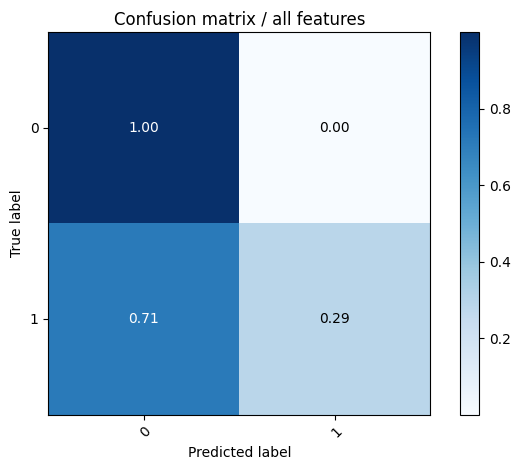

In [27]:
classes = pd.Series([0,1])

plot_confusion_matrix(y_train_valid_part, y_all_features.round(), classes=classes, normalize=True,
                      title='Confusion matrix / all features')

plt.show()

Normalized confusion matrix
[[9.99370843e-01 6.29156930e-04]
 [7.08148559e-01 2.91851441e-01]]


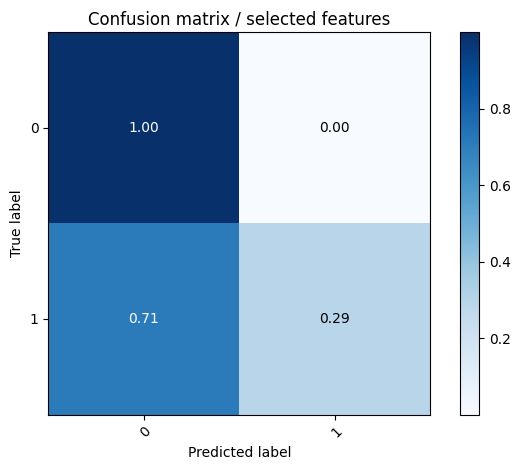

In [28]:
plot_confusion_matrix(y_train_valid_part, y_selected_features.round(), classes=classes, normalize=True,
                      title='Confusion matrix / selected features')

plt.show()

# 6 ROC curve

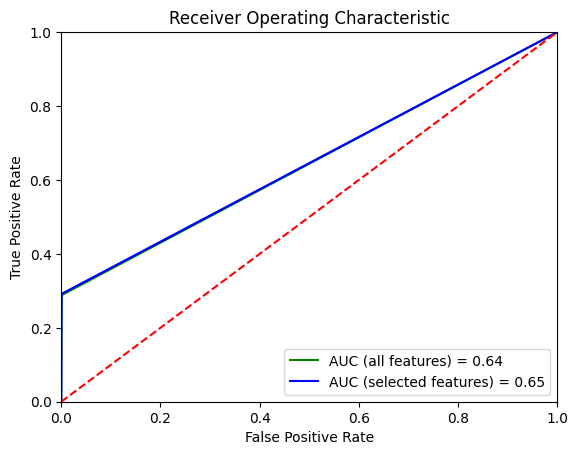

In [29]:
# From https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
#  and https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_all_features, tpr_all_features, _ = roc_curve(y_train_valid_part, y_all_features.round())
roc_auc_all_features = auc(fpr_all_features, tpr_all_features)

fpr_selected_features, tpr_selected_features, _ = roc_curve(y_train_valid_part, y_selected_features.round())
roc_auc_selected_features = auc(fpr_selected_features, tpr_selected_features)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_all_features, tpr_all_features, 'g', label = 'AUC (all features) = %0.2f' % roc_auc_all_features)
plt.plot(fpr_selected_features, tpr_selected_features, 'b', label = 'AUC (selected features) = %0.2f' % roc_auc_selected_features)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()